In [20]:
#%pip install fastparquet
%pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
df = pd.read_parquet('indicators.parquet', engine='fastparquet')


In [18]:
print(df.dtypes)

Country Name       object
Country Code       object
Indicator Name     object
Indicator Code     object
1960              float64
                   ...   
2020              float64
2021              float64
2022              float64
2023              float64
2024              float64
Length: 69, dtype: object


In [25]:
year_cols = [c for c in df.columns if c.isdigit()]

In [32]:
# Compute missing fraction per (country, indicator) time series
df["missing_fraction"] = df[year_cols].isna().mean(axis=1)

missing_by_indicator = (
    df.groupby(["Indicator Code","Indicator Name"])["missing_fraction"]
      .mean()
      .reset_index(name="avg_missing_fraction")
      .sort_values("avg_missing_fraction")   # << lowest first
)

# Show the top 50 *least missing* indicators
missing_by_indicator.head(100)

,Indicator Code,Indicator Name,avg_missing_fraction
1278,SM.POP.NETM,Net migration,0.003759
1352,SP.POP.6569.MA.5Y,"Population ages 65-69, male (% of male populat...",0.003759
1350,SP.POP.6064.MA.5Y,"Population ages 60-64, male (% of male populat...",0.003759
1318,SP.POP.0014.MA.ZS,"Population ages 0-14, male (% of male population)",0.003759
1347,SP.POP.5559.FE.5Y,"Population ages 55-59, female (% of female pop...",0.003759
...,...,...,...
549,IT.MLT.MAIN,Fixed telephone subscriptions,0.171833
718,NY.GDP.MKTP.KD,GDP (constant 2015 US$),0.176750
726,NY.GDP.PCAP.KD,GDP per capita (constant 2015 US$),0.176750
8,AG.LND.CROP.ZS,Permanent cropland (% of land area),0.178311


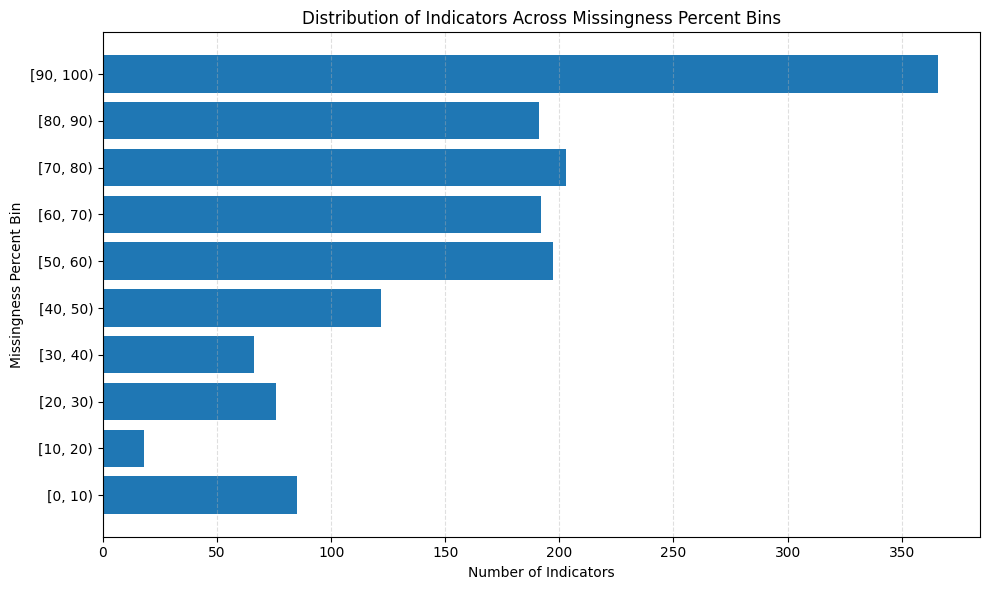

In [46]:
# Convert missingness to percent if not done yet
missing_by_indicator["missing_percent"] = (
    missing_by_indicator["avg_missing_fraction"] * 100
)

# Create bins (adjust size as needed)
bins = range(0, 110, 10)  # 0%-100% in increments of 10%

# Bin the missingness percentages
missing_by_indicator["bin"] = pd.cut(
    missing_by_indicator["missing_percent"],
    bins=bins,
    include_lowest=True,
    right=False
)

# Count how many indicators fall into each missingness bin
counts = missing_by_indicator["bin"].value_counts().sort_index()

# Make a horizontal bar chart
plt.figure(figsize=(10,6))
plt.barh(counts.index.astype(str), counts.values)
plt.xlabel("Number of Indicators")
plt.ylabel("Missingness Percent Bin")
plt.title("Distribution of Indicators Across Missingness Percent Bins")
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [40]:
good_indicators = missing_by_indicator[missing_by_indicator["avg_missing_fraction"] < 0.3]

In [41]:
print(good_indicators[["Indicator Code", "Indicator Name", "avg_missing_fraction"]])

            Indicator Code                                     Indicator Name  \
1278           SM.POP.NETM                                      Net migration   
1352     SP.POP.6569.MA.5Y  Population ages 65-69, male (% of male populat...   
1350     SP.POP.6064.MA.5Y  Population ages 60-64, male (% of male populat...   
1318     SP.POP.0014.MA.ZS  Population ages 0-14, male (% of male population)   
1347     SP.POP.5559.FE.5Y  Population ages 55-59, female (% of female pop...   
...                    ...                                                ...   
767            PA.NUS.ATLS    DEC alternative conversion factor (LCU per US$)   
768            PA.NUS.FCRF  Official exchange rate (LCU per US$, period av...   
1457     TX.VAL.MRCH.AL.ZS  Merchandise exports to economies in the Arab W...   
272   EN.GHG.CO2.RT.GDP.KD  Carbon intensity of GDP (kg CO2e per constant ...   
68       BX.KLT.DINV.CD.WD  Foreign direct investment, net inflows (BoP, c...   

      avg_missing_fraction 